In [9]:
from datetime import datetime

from siphon.catalog import TDSCatalog
import xarray as xr
import metpy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import numpy as np

In [11]:
todays_date = datetime.utcnow().date()
todays_date = todays_date.strftime('%Y%m%d')

radar = TDSCatalog(f'https://thredds.ucar.edu/thredds/catalog/nexrad/composite/gini/dhr/1km/{todays_date}/catalog.xml')
data = radar.datasets[0].remote_access(use_xarray=True)
data = data.metpy.parse_cf()

ds = data['Reflectivity'].squeeze()
plot_proj = ds.metpy.cartopy_crs
location = plot_proj.transform_point(-81.31, 29.37, ccrs.PlateCarree())
x, y = location

In [12]:
point = ds.squeeze().metpy.sel(x=x, y=y, method='nearest')
print(point.values)

29.0


In [13]:
def convert_latlon_to_xy(ds, lat, lon):
    plot_proj = ds.metpy.cartopy_crs
    location = plot_proj.transform_point(lon, lat, ccrs.PlateCarree())
    x, y = location
    return x, y

def get_grid_value(ds, x, y):
    point = ds.squeeze().metpy.sel(x=x, y=y, method='nearest')
    return point.values

pt_x, pt_y = convert_latlon_to_xy(ds, 30.82, -82.60)
value = get_grid_value(ds, pt_x, pt_y)
print(value)

9.0


/Users/rhawthorne/miniconda3/envs/metpy_v1/lib/python3.9/site-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/Users/rhawthorne/miniconda3/envs/metpy_v1/lib/python3.9/site-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/Users/rhawthorne/miniconda3/envs/metpy_v1/lib/python3.9/site-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


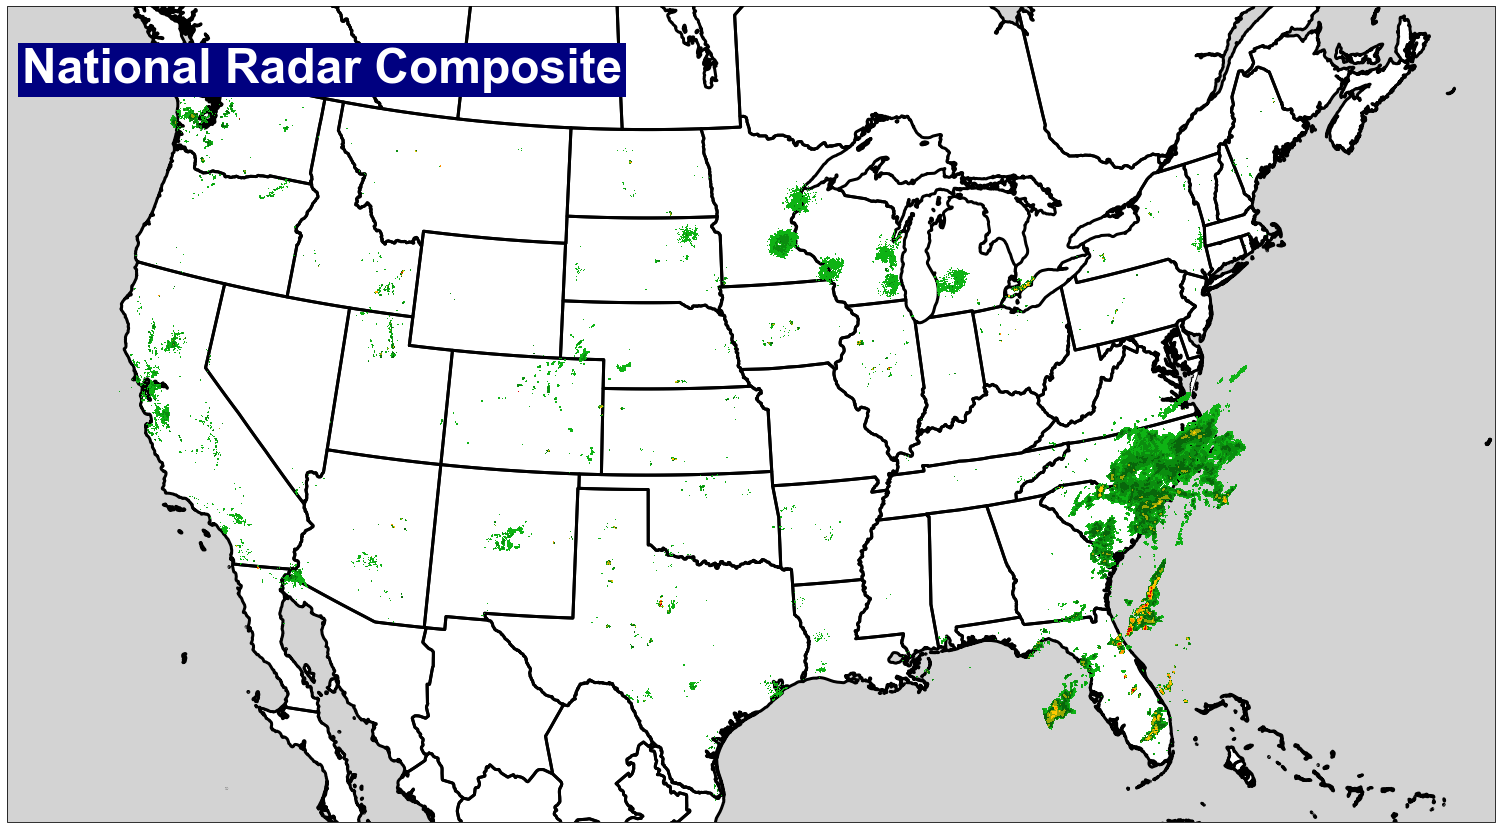

In [14]:
fig = plt.figure(figsize=(1920/72, 1080/72))
ax = fig.add_subplot(1, 1, 1, projection=plot_proj)
ax.set_extent((-122, -70, 25, 50), crs=ccrs.PlateCarree())

# Add state lines, coastlines, map extent
ax.add_feature(cfeature.OCEAN.with_scale('10m'), color='lightgray')
ax.add_feature(cfeature.COASTLINE.with_scale('10m'), linewidth=0.75)
ax.add_feature(cfeature.STATES.with_scale('10m'), linewidth=3.00)
ax.set_adjustable('datalim')

# Define Colormap
norm, cmap = metpy.plots.ctables.registry.get_with_steps('NWSStormClearReflectivity', 20, 5)

# Display Banner
plt.text(0.01, 0.95, s='National Radar Composite',
         fontname='Arial', fontsize=48, fontweight='bold', color='white',
         bbox={'facecolor': 'navy', 'alpha': 1.0, 'edgecolor': 'none'},
         transform=ax.transAxes, zorder=10, va='top')

ax.contourf(ds.metpy.x, ds.metpy.y, ds, np.arange(20, 80, 5), cmap=cmap,
            norm=Normalize(-30, 80),
            transform=plot_proj)
